In [1]:
%load_ext autoreload
%autoreload 2
import os
import json
import numpy as np
import pandas as pd
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

MPL_CUSTOM = {
    'font.family': 'serif',
    'mathtext.fontset': 'cm',
    'figure.dpi': 120,
    'figure.figsize': (4, 3.5),
    'figure.facecolor': 'white',
    'xtick.top': True,
    'xtick.direction': 'in',
    'xtick.minor.visible': True,
    'ytick.right': True,
    'ytick.direction': 'in',
    'ytick.minor.visible': True,
}

for k, v in MPL_CUSTOM.items():
    mpl.rcParams[k] = v

In [2]:
current_dir = Path(os.getcwd())
project_dir = current_dir.parent.parent.absolute()

In [3]:
kernel_pth = project_dir / 'database/kernel/pp/1mev.npz'
assert Path(kernel_pth).exists()
q, r, kernel = np.load(kernel_pth).values()
q.shape, r.shape, kernel.shape

((200,), (800,), (200, 800))

In [4]:
def rebin(X:np.ndarray, bins=None, ranges=None, return_bincenters=False):

    x = np.unique(X[:,0])
    y = np.unique(X[:,1])
    dx = x[1] - x[0]
    dy = y[1] - y[0]

    if bins is None:
        bins = [len(x), len(y)]
    if ranges is None:
        ranges = [
            [x.min() - dx / 2, x.max() + dx / 2],
            [y.min() - dy / 2, y.max() + dy / 2]
        ]

    hist, xedges, yedges = np.histogram2d(
        X[:,0],
        X[:,1],
        weights = X[:,2],
        bins = bins,
        range = ranges
    )

    bincount = np.histogram2d(X[:,0], X[:,1], bins, ranges)[0]
    hist_rebinned = np.divide(hist, bincount, out=np.zeros_like(hist), where=bincount!=0)
    x_rebinned = 0.5 * (xedges[1:] + xedges[:-1])
    y_rebinned = 0.5 * (yedges[1:] + yedges[:-1])
    
    if return_bincenters:
        return x_rebinned, y_rebinned, hist_rebinned
    
    xx, yy = np.meshgrid(x_rebinned, y_rebinned, indexing='ij')
    return np.transpose([
        xx.flatten(),
        yy.flatten(),
        hist_rebinned.flatten()
    ])
    

In [5]:
qrebin = 4
qrange = [0, 80]
rrange = [0.05, 36.05]
rbins = 12
qbins = int(qrange[1] / qrebin)

qq, rr = np.meshgrid(q, r, indexing='ij')
q, r, kernel = rebin(
    np.transpose([qq.flatten(), rr.flatten(), kernel.flatten()]),
    bins = [qbins, rbins],
    ranges = [qrange, rrange],
    return_bincenters = True
)

dr = r[1] - r[0]
dq = q[1] - q[0]


In [6]:
def gaus_source(r, R, lambda_=1.):
    return lambda_ / (2 * np.sqrt(np.pi) * R)**3 * np.exp(-r**2 / 4 / R**2)

R_true = 3.5
lambda_true = 0.8

In [7]:
S_true = gaus_source(r, R_true, lambda_true)
K_true = 4 * np.pi * (kernel + 1./ lambda_true) * r ** 2 * dr
C_true = np.dot(K_true, S_true)

In [8]:
def richardson_lucy_std(niter, X, y, psf, return_all=False):
    y_norm = np.sum(y)
    psf_norm = np.sum(psf, axis=0)

    psf_ = psf / psf_norm
    img = y / y_norm
    deconv = X / np.sum(X)
    conv = np.dot(psf_, deconv) + 1e-12


    X_preds = []
    y_preds = []

    for _ in range(niter):
        deconv = deconv * np.einsum('i,ij', img / conv, psf_)
        conv = np.dot(psf_, deconv) + 1e-12

        X_preds.append(deconv * y_norm / psf_norm)
        y_preds.append(conv * y_norm)
        
    if return_all:
        return X_preds, y_preds
    
    return X_preds[-1], y_preds[-1]

In [9]:
R_guess = 5.0
lambda_guess = lambda_true
S_guess = gaus_source(r, R_guess, lambda_guess)
K = 4 * np.pi * (kernel + 1./ lambda_guess) * r ** 2 * dr

In [10]:
restored_list, predicted_list = richardson_lucy_std(
    niter = 800000, 
    X = S_guess,
    y = C_true, 
    psf = K, 
    return_all = True
)

In [11]:
flat_guess = np.ones_like(S_guess)
flat_guess /= np.sum(flat_guess * 4 * np.pi * r**2 * dr)
flat_guess *= lambda_guess

In [12]:
restored_list_flat, predicted_list_flat = richardson_lucy_std(
    niter = 800000, 
    X = flat_guess,
    y = C_true, 
    psf = K, 
    return_all = True
)

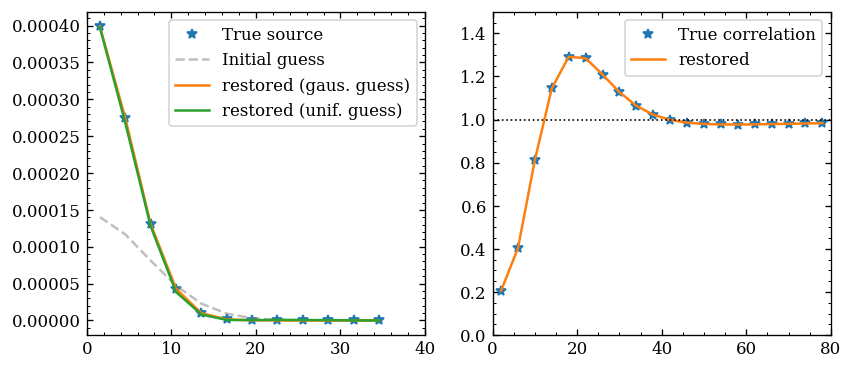

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

axes[1].plot(q, C_true, label='True correlation', marker='*', ls='none')
axes[1].plot(q, predicted_list[-1], label=f'restored', ls='-')

axes[0].plot(r, S_true, label='True source', marker='*', ls='none')
axes[0].plot(r, S_guess, label='Initial guess', ls='--', color='gray', alpha=0.5)

axes[0].plot(r, restored_list[-1], label='restored (gaus. guess)', ls='-')
axes[0].plot(r, restored_list_flat[-1], label='restored (unif. guess)', ls='-')

axes[1].axhline(1, color='k', ls=':', lw=1)

axes[0].set_xlim(0, 40)
axes[1].set_xlim(0, 80)
axes[1].set_ylim(0, 1.5)

axes[0].legend()
axes[1].legend()

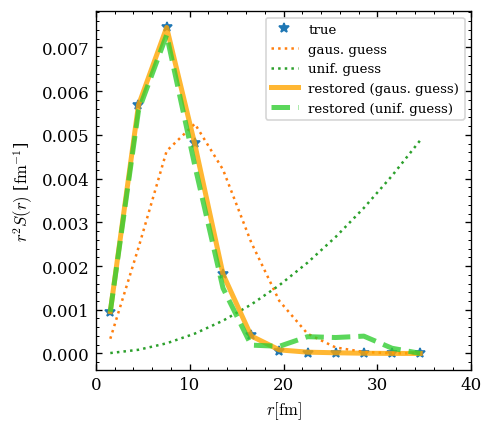

In [19]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(r, S_true * r ** 2, label='true', marker='*', ls='none')
ax.plot(r, S_guess * r ** 2, label='gaus. guess', ls=':')
ax.plot(r, flat_guess * r ** 2, label='unif. guess', ls=':')

ax.plot(r, restored_list[-1] * r ** 2, label='restored (gaus. guess)', ls='-', lw=3, color='orange', alpha=0.8)
ax.plot(r, restored_list_flat[-1] * r ** 2, label='restored (unif. guess)', ls='--', lw=3, color='limegreen', alpha=0.8)

ax.set_xlim(0, 40)
ax.set_xlabel(r'$r [\mathrm{fm}]$')
ax.set_ylabel(r'$r^2 S(r)$ [$\mathrm{fm}^{-1}$]')

ax.legend(fontsize=8)
plt.show()
